In [1]:
import pandas as pd
import zipfile
import os
import cv2
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import torch
import copy
import random
import torch.nn as nn
import torch.optim as optim

from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS as sklear_stopwords
from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_confusion_matrix
from sklearn.utils import class_weight

from nltk.corpus import stopwords

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, GaussianNoise, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.callbacks import EarlyStopping

from torch.utils.data import DataLoader, TensorDataset
from torchvision import models

sns.set_style('whitegrid')
sns.set_context('notebook')

In [2]:
df = pd.read_csv('artists.csv')
df.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


# data preparation

- unpack zip folder with the data
- retrieve labels from filenames
- load images as lists
- pickle the images and the labels

In [ ]:
def prepare_data(folder_name, zip_name, size, mode=1, to_pickle=True):
    
    if not os.path.exists(folder_name):
        with zipfile.ZipFile(zip_name, 'r') as archive:
            for file in archive.namelist():
                if file.startswith('resized/') and file != 'resized/':
                    archive.extract(file)
                    
        os.rename('resized', folder_name)
            
    labels, paintings = [], []
    for filename in os.listdir(folder_name):
        path = os.path.join(folder_name, filename)

        if 'Albrecht_D' in filename:
            filename = filename.replace(filename.split('_')[1], 'Durer')
            new_path = os.path.join(folder_name, filename)
            os.rename(path, new_path)
            path = new_path

        labels.append(' '.join(filename.split('_')[:-1]))

        image = cv2.cvtColor(cv2.imread(path, mode), cv2.COLOR_BGR2RGB)
        paintings.append(cv2.resize(image, (size,size)))

    if to_pickle == True:
        with open('paintings', 'wb') as file:
            pickle.dump(paintings, file)
        with open('labels', 'wb') as file:
            pickle.dump(labels, file)
    
    return labels, paintings

In [ ]:
labels, paintings = prepare_data('images', 'resized.zip', size=96)

# eda

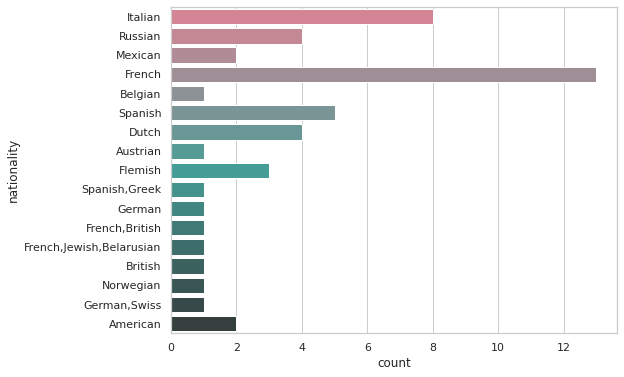

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, y='nationality', palette='husl_d');

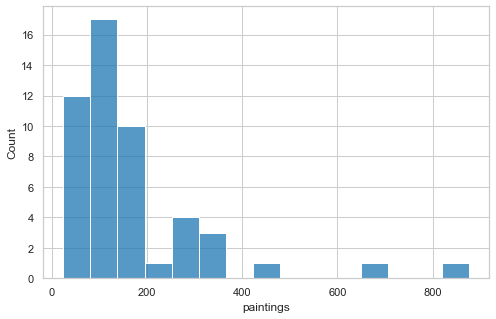

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='paintings');

In [ ]:
df[['name','paintings']].sort_values('paintings', ascending=False)[:10]

,name,paintings
8,Vincent van Gogh,877
30,Edgar Degas,702
13,Pablo Picasso,439
15,Pierre-Auguste Renoir,336
19,Albrecht Dürer,328
46,Paul Gauguin,311
16,Francisco Goya,291
31,Rembrandt,262
20,Alfred Sisley,259
32,Titian,255


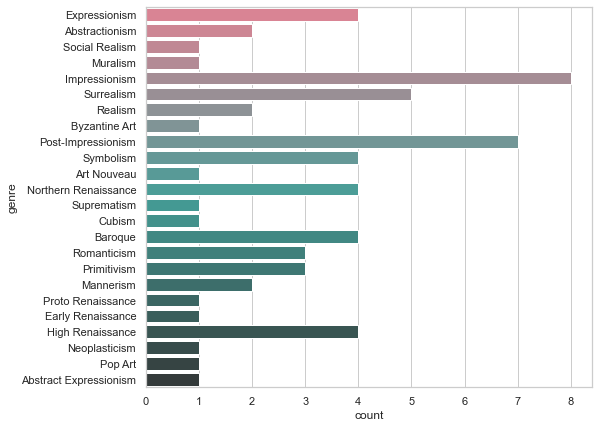

In [ ]:
genres = ','.join(list(df['genre'].values)).split(',')

plt.figure(figsize=(8,7))
sns.countplot(y=genres, palette='husl_d');
plt.ylabel('genre');

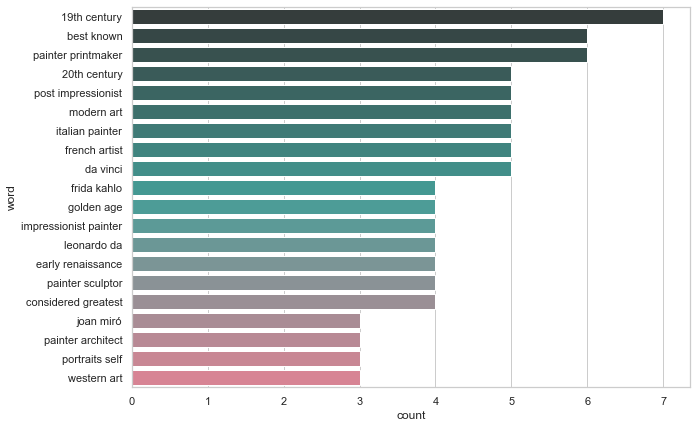

In [ ]:
#nltk.download('stopwords')
all_sw = list(sklear_stopwords) + stopwords.words('english')
count_vectorizer = CountVectorizer(stop_words = all_sw, max_features=20, ngram_range=(2,2))
fit = count_vectorizer.fit_transform(df['bio'])

counts = pd.DataFrame({'word':count_vectorizer.get_feature_names(), 'count':fit.sum(axis=0).tolist()[0]})
counts = counts.sort_values(by=['count'], ascending=False).reset_index(drop=True)

plt.figure(figsize=(10,7))
sns.barplot(y=counts['word'], x=counts['count'], palette='husl_r_d');

some of the paintings

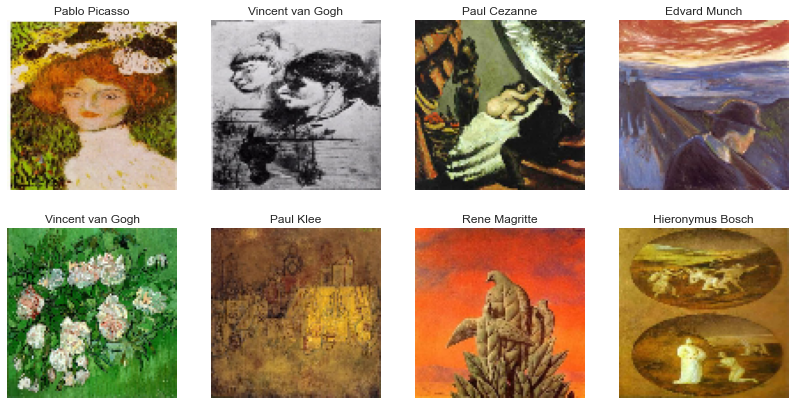

In [ ]:
fig, axes = plt.subplots(2,4, figsize=(14,7))
axes = axes.flatten()
for i in range(8):
    k = random.randint(0, len(paintings))
    axes[i].imshow(paintings[k]);
    axes[i].axis('off');
    axes[i].set_title(labels[k]);

In [ ]:
size = 96

In [ ]:
rgb = np.array(paintings).reshape(-1,size,size,3).reshape(-1, 3)
unique_colours, counts = np.unique(rgb, return_counts=True, axis=0)
colours = pd.DataFrame({'colour':list(unique_colours), 'count':counts}).sort_values('count', ascending=False)

400 most/least frequent colors shown on a grid

In [ ]:
most_100 = colours[:400].copy()
least_100 = colours[-400:].copy()

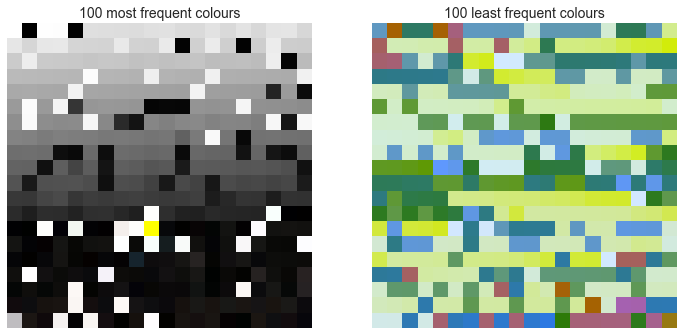

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,8))
axes[0].imshow(np.stack(most_100['colour'].values, axis=0).reshape(20,20,3));
axes[1].imshow(np.stack(least_100['colour'].values, axis=0).reshape(20,20,3));
for i in [0,1]:
    axes[i].grid(False);
    axes[i].axis('off');
    which = 'most' if i == 0 else 'least'
    axes[i].set_title(fr'100 {which} frequent colours', fontsize=14)

this yellow tile in 100 most frequent colours is quite interesting

# classification
having pickled paintings and labels I move to Google Colab and its GPU

In [55]:
def evaluate_model(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')

    df = pd.DataFrame({'accuracy':[acc], 'recall':[rec], 'precision':[prec]})
    display(df)

In [56]:
size = 96

In [57]:
paintings, labels = pickle.load(open('paintings','rb')), pickle.load(open('labels','rb'))

dataset is not balanced, so I compute weights

In [58]:
unique_labels = sorted(list(set(labels)))
weights = class_weight.compute_class_weight('balanced', unique_labels, labels)
weights_dict = dict(zip(np.arange(len(unique_labels)), weights))

In [59]:
labels = pd.Series(labels).map(dict(zip(unique_labels, np.arange(len(unique_labels))))).values
paintings = np.array(paintings).reshape(-1,size,size,3).astype('float32') / 255 #channels last

train, test and validation sets

In [60]:
X_train, X_test, y_train, y_test = train_test_split(paintings, labels, stratify=labels,
                                                    test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train,
                                                  test_size=0.1, random_state=42)

In [61]:
X_train.shape, X_val.shape, X_test.shape

((6767, 96, 96, 3), (752, 96, 96, 3), (836, 96, 96, 3))

In [62]:
y_train = to_categorical(y_train, 50)
y_val = to_categorical(y_val, 50)

## Keras model

In [67]:
model = Sequential()

model.add(Input(shape=(size,size,3)))

model.add(RandomFlip("horizontal"))
model.add(RandomRotation(0.1))

model.add(Conv2D(32, (5,5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (5,5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(2000, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='softmax'))

es = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=3)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=64, epochs=150,
                callbacks=[es], class_weight=weights_dict)

Epoch 1/150
106/106 [==============================] - 8s 71ms/step - loss: 4.0214 - accuracy: 0.0368 - val_loss: 3.5927 - val_accuracy: 0.0984
Epoch 2/150
106/106 [==============================] - 7s 69ms/step - loss: 3.7121 - accuracy: 0.0590 - val_loss: 3.4576 - val_accuracy: 0.1303
Epoch 3/150
106/106 [==============================] - 7s 68ms/step - loss: 3.4000 - accuracy: 0.1005 - val_loss: 3.3538 - val_accuracy: 0.1330
Epoch 4/150
106/106 [==============================] - 7s 68ms/step - loss: 3.2931 - accuracy: 0.1279 - val_loss: 3.2498 - val_accuracy: 0.1290
Epoch 5/150
106/106 [==============================] - 7s 69ms/step - loss: 3.1160 - accuracy: 0.1547 - val_loss: 3.1946 - val_accuracy: 0.1463
Epoch 6/150
106/106 [==============================] - 7s 68ms/step - loss: 2.9909 - accuracy: 0.1736 - val_loss: 3.0982 - val_accuracy: 0.1622
Epoch 7/150
106/106 [==============================] - 7s 69ms/step - loss: 2.8261 - accuracy: 0.1907 - val_loss: 3.0621 - val_accuracy:

In [68]:
y_pred_class = np.argmax(model.predict(X_val), axis=-1)
evaluate_model(np.argmax(y_val, axis=-1), y_pred_class)

,accuracy,recall,precision
0,0.267287,0.267287,0.346875


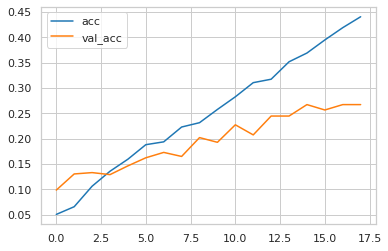

In [69]:
plt.plot(fit.history['accuracy'], label='acc');
plt.plot(fit.history['val_accuracy'], label='val_acc');
plt.legend();

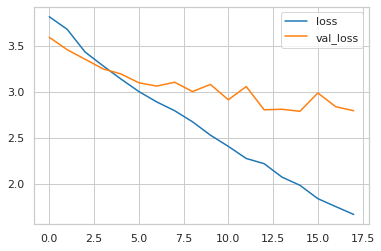

In [70]:
plt.plot(fit.history['loss'], label='loss');
plt.plot(fit.history['val_loss'], label='val_loss');
plt.legend();

## transfer learning

based on [PyTorch tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) and code used for transfer learning in my [other project](https://github.com/kamilabielska/coronavirus_tweets)

In [32]:
device = torch.device("cuda")

In [33]:
paintings, labels = pickle.load(open('paintings','rb')), pickle.load(open('labels','rb'))

unique_labels = sorted(list(set(labels)))
labels = pd.Series(labels).map(dict(zip(unique_labels, np.arange(len(unique_labels))))).values
paintings = np.array(paintings).reshape(-1,3,size,size).astype('float32') / 255 #channels first

In [35]:
X_train, X_test, y_train, y_test = train_test_split(paintings, labels, stratify=labels,
                                                    test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train,
                                                  test_size=0.1, random_state=42)

In [50]:
train_data = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_data = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=16, shuffle=True)

In [51]:
data_size = {'train': len(X_train), 'val': len(X_val)}

In [52]:
def train_model(model, criterion, optimizer, scheduler, epochs):
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0

    for epoch in range(epochs):
        print('')
        print(fr'======== Epoch {epoch + 1} / {epochs} ========')
        print('Training...')
        t0 = time.time()

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
                dataloader = train_dataloader
            else:
                model.eval()
                dataloader = val_dataloader

            running_loss = 0
            running_corrects = 0

            for step, batch in enumerate(dataloader):
                if step % 50 == 0 and not step == 0:
                    print(fr'Batch {step:>5,} of {len(dataloader):>5,}. Elapsed: {time.time() - t0}.')

                inputs = batch[0].to(device)
                labels = batch[1].to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
            
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() *inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'learn':
                scheduler.step()

            epoch_loss = running_loss/data_size[phase]
            epoch_accuracy = running_corrects.double()/data_size[phase]

            print(fr'== {phase} == loss: {epoch_loss:.4f} accuracy: {epoch_accuracy:.4f}')

            if phase == 'val' and epoch_accuracy > best_acc:
                best_acc = epoch_accuracy
                best_model_wts = copy.deepcopy(model.state_dict())

        model.load_state_dict(best_model_wts)
        return model

In [53]:
model_ft = models.resnet18(pretrained=True)
num_features = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_features, 50)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights).float().to(device))
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [54]:
model = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, epochs=5)


======== Epoch 1 / 5 ========
Training...
Batch    50 of   423. Elapsed: 10.05879259109497.
Batch   100 of   423. Elapsed: 20.091190099716187.
Batch   150 of   423. Elapsed: 30.13557481765747.
Batch   200 of   423. Elapsed: 40.171478033065796.
Batch   250 of   423. Elapsed: 50.22366714477539.
Batch   300 of   423. Elapsed: 60.25492191314697.
Batch   350 of   423. Elapsed: 70.18962788581848.
Batch   400 of   423. Elapsed: 80.13817381858826.
== train == loss: 3.5802 accuracy: 0.1129
== val == loss: 3.1405 accuracy: 0.1835

======== Epoch 2 / 5 ========
Training...
Batch    50 of   423. Elapsed: 9.96357250213623.
Batch   100 of   423. Elapsed: 19.9283287525177.
Batch   150 of   423. Elapsed: 29.94534468650818.
Batch   200 of   423. Elapsed: 39.989221811294556.
Batch   250 of   423. Elapsed: 50.02227592468262.
Batch   300 of   423. Elapsed: 60.07670974731445.
Batch   350 of   423. Elapsed: 70.11996865272522.
Batch   400 of   423. Elapsed: 80.15158772468567.
== train == loss: 2.9285 accura